# Xgboost Classification

In [1]:
import numpy as np 
import pandas as pd 


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE

import xgboost as xgb  # Load this xgboost

from sklearn.model_selection import train_test_split


# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split


In [2]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


# 1. Exploratory Data Analysis

Let us load in the dataset via the trusty Pandas package into a dataframe object which we call **attrition** and have a quick look at the first few rows

In [3]:
attrition = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Looking for NaN
attrition.isnull().any()

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [5]:
# attrition.Age.fillna('')

### Correlation of Features


In [6]:
# attrition.corr()

#  Feature Engineering & Categorical Encoding

Task of Feature engineering and numerically encoding the categorical values in our dataset.

In [7]:
# attrition.shape

In [8]:
attrition.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [9]:
# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.items():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attrition.columns.difference(categorical)

print("Categorical columns:", categorical)
print("Numerical columns:", numerical)

Categorical columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Numerical columns: Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


In [10]:
numerical

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [11]:
categorical

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [12]:
# Store the categorical data in a dataframe called attrition_cat
attrition_cat = attrition[categorical]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column

In [13]:
attrition_cat

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
...,...,...,...,...,...,...,...,...
1465,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
1466,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,Y,No
1467,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Y,Yes
1468,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,Y,No


Applying the **get_dummies** method

In [14]:
attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,False,False,True,False,False,True,False,True,False,False,...,False,False,True,False,False,False,True,True,False,True
1,False,True,False,False,True,False,False,True,False,False,...,False,True,False,False,False,True,False,True,True,False
2,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True


In [15]:
# Store the numerical features to a dataframe attrition_num
attrition_num = attrition[numerical]

let's concat numerical and caterogial dfs

In [16]:
# Concat the two dataframes together columnwise
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1)

In [17]:
attrition_final.shape

(1470, 55)

In [18]:
attrition_final.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1102,1,2,1,1,2,94,3,2,...,False,False,True,False,False,False,True,True,False,True
1,49,279,8,1,1,2,3,61,2,2,...,False,True,False,False,False,True,False,True,True,False
2,37,1373,2,2,1,4,4,92,2,1,...,False,False,False,False,False,False,True,True,False,True
3,33,1392,3,4,1,5,4,56,3,1,...,False,True,False,False,False,True,False,True,False,True
4,27,591,2,1,1,7,1,40,3,1,...,False,False,False,False,False,True,False,True,True,False


**Target variable**

The target in this case is given by the column **Attrition** which contains categorical variables therefore requires numerical encoding. We numerically encode it by creating a dictionary with the mapping given as 1 : Yes and 0 : No

In [19]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = attrition["Attrition"].apply(lambda x: target_map[x])
target.head(3)

0    1
1    0
2    1
Name: Attrition, dtype: int64


**Splitting Data into Train and Test sets**


In [20]:
# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_test = train_test_split(attrition_final, target, train_size= 0.75,random_state=0);

#  Implementing Machine Learning Models


## Xgboost Classifier



### 1.n_estimators - No of Trees in the Model

### 2.max_leaf_nodes = The maximum number of terminal nodes or leaves in a tree. If this is defined, max_depth will be ignored

### 3.min_child_weight - Defines the minimum sum of weights of all observations required in a child.

### 4.max_depth - Maximum Depth of Tree and can be used to control overfiting 

### 5.subsample- The fraction of samples to be used for fitting the individual base learners

### 6.learning_rate - Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators

## Regularization parameters

### 7. gamma - A node is split only when the resulting split gives a postive Gain. Gamma specifies the minimum loss reduction required to make a split.

### 8. lambda - This used to handle the regularization part of XGBoost. It should be explored to reduce overfitting

## Imbalanced Data Handling

### 9. scale_pos_weight - A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence

In [21]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [22]:
# Fit the model to our train and target
xgb_cfl.fit(train, target_train)  # default 
# Get our predictions
xgb_predictions = xgb_cfl.predict(test)

In [23]:
xgb_predictions_prob = xgb_cfl.predict_proba(test)
xgb_predictions_prob

array([[9.80802476e-01, 1.91975068e-02],
       [9.99925792e-01, 7.42326592e-05],
       [9.68313873e-01, 3.16861533e-02],
       [9.69120681e-01, 3.08792982e-02],
       [4.23973799e-03, 9.95760262e-01],
       [6.50538146e-01, 3.49461854e-01],
       [7.71121085e-01, 2.28878915e-01],
       [9.77243125e-01, 2.27568597e-02],
       [9.96759653e-01, 3.24033108e-03],
       [9.28561509e-01, 7.14384764e-02],
       [9.99308348e-01, 6.91627502e-04],
       [9.75794256e-01, 2.42057461e-02],
       [9.99040246e-01, 9.59759229e-04],
       [7.03077316e-02, 9.29692268e-01],
       [9.99101222e-01, 8.98779952e-04],
       [9.99957383e-01, 4.25999897e-05],
       [9.95473862e-01, 4.52613644e-03],
       [9.99491930e-01, 5.08057943e-04],
       [9.75677967e-01, 2.43220292e-02],
       [9.87874329e-01, 1.21256514e-02],
       [8.60899210e-01, 1.39100775e-01],
       [9.94047403e-01, 5.95258083e-03],
       [9.99224126e-01, 7.75870751e-04],
       [9.99883235e-01, 1.16776842e-04],
       [5.050388

In [24]:
accuracy_score(target_test, xgb_predictions)

0.8695652173913043

# HPT - Random Search

In [25]:
# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5

param_comb = 800

random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42)


In [27]:
random_search.fit(train, target_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, min_child_weight=7, n_estimators=500, subsample=0.6;, score=0.864 total time=   1.3s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, min_child_weight=7, n_estimators=500, subsample=0.6;, score=0.877 total time=   1.2s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, min_child_weight=7, n_estimators=500, subsample=0.6;, score=0.859 total time=   1.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.02, max_depth=4, min_child_weight=1, n_estimators=500, subsample=1.0;, score=0.855 total time=   1.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.02, max_depth=4, min_child_weight=1, n_estimators=500, subsample=1.0;, score=0.873 total time=   0.8s
[CV 5/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.02, max_depth=4, min_child_weight=1, n_estimators=500, su

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=800, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.5, 1, 1.5, 5],
                                        'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [3, 4, 5, 10, 12],
                                        'min_child_weight': [1, 5, 7, 10],
                                        'n_estimators': [100, 200, 500, 750],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=3)

In [28]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

 Best accuracy for 5-fold search with 800 parameter combinations:
0.8793253805018513

 Best hyperparameters:
{'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_

In [29]:
xgb_predictions_hpt = random_search.predict(test)
accuracy_score(target_test, xgb_predictions_hpt)

0.8831521739130435

#### Score here shows that HPT helped improving the Model accuracy

### Feature Importance Xgboost Model


In [30]:
xgb_cfl.feature_importances_

array([0.02663871, 0.01600106, 0.01433308, 0.01167052, 0.        ,
       0.01372479, 0.02261208, 0.01608823, 0.02286761, 0.0503764 ,
       0.02042658, 0.02043496, 0.01375093, 0.02660762, 0.01451358,
       0.        , 0.01975274, 0.        , 0.02983482, 0.01363983,
       0.01295772, 0.01620325, 0.0169708 , 0.01497729, 0.01723427,
       0.04283749, 0.00261417, 0.03125522, 0.05138135, 0.        ,
       0.01664683, 0.01017353, 0.        , 0.01151736, 0.01584176,
       0.01469793, 0.        , 0.01378211, 0.01465011, 0.        ,
       0.        , 0.        , 0.0163368 , 0.03206247, 0.0894463 ,
       0.        , 0.01567406, 0.03245819, 0.01162295, 0.02320496,
       0.01343417, 0.0640484 , 0.        , 0.04469697, 0.        ],
      dtype=float32)

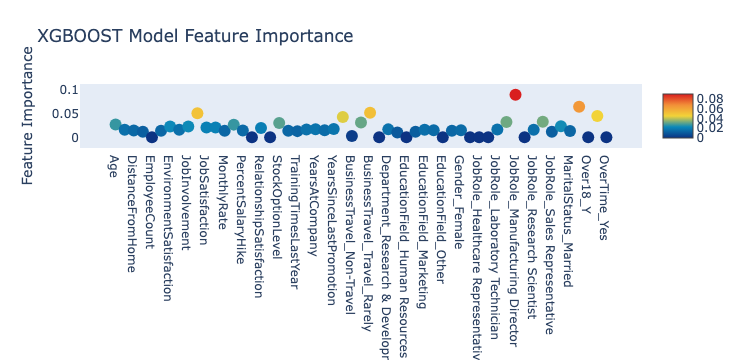

In [32]:
# Scatter plot 
trace = go.Scatter(
    y = xgb_cfl.feature_importances_,
    x = attrition_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1.3,
        size = 12,
        color = xgb_cfl.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = attrition_final.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'XGBOOST Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')